##1️⃣ ติดตั้งไลบรารี

In [1]:
!pip install GEOparse pandas numpy scipy scikit-learn matplotlib seaborn statsmodels


##🧠 2️⃣ โหลด GEO Dataset

In [2]:
import GEOparse, pandas as pd, numpy as np

gse = GEOparse.get_GEO("GSE66360", destdir=".")
expr = gse.pivot_samples("VALUE")
pheno = gse.phenotype_data


01-Feb-2026 21:09:54 DEBUG utils - Directory . already exists. Skipping.
DEBUG:GEOparse:Directory . already exists. Skipping.
01-Feb-2026 21:09:54 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE66nnn/GSE66360/soft/GSE66360_family.soft.gz to ./GSE66360_family.soft.gz
INFO:GEOparse:Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE66nnn/GSE66360/soft/GSE66360_family.soft.gz to ./GSE66360_family.soft.gz
100%|██████████| 68.5M/68.5M [00:01<00:00, 42.8MB/s]
01-Feb-2026 21:09:56 DEBUG downloader - Size validation passed
DEBUG:GEOparse:Size validation passed
01-Feb-2026 21:09:56 DEBUG downloader - Moving /tmp/tmp8bzf0klv to /content/GSE66360_family.soft.gz
DEBUG:GEOparse:Moving /tmp/tmp8bzf0klv to /content/GSE66360_family.soft.gz
01-Feb-2026 21:09:57 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE66nnn/GSE66360/soft/GSE66360_family.soft.gz
DEBUG:GEOparse:Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE66nnn/GSE6636

##🧹 3️⃣ ลบ Outliers (เหมือน paper)

In [3]:
outliers = ["GSM1620857","GSM1620858","GSM1620894","GSM1620899",
            "GSM1620912","GSM1620872","GSM1620885","GSM1620892","GSM1620913"]

# Filter outliers to only include those present in expr columns
existing_outliers_expr = [o for o in outliers if o in expr.columns]
expr = expr.drop(columns=existing_outliers_expr)

# Filter outliers to only include those present in pheno index
existing_outliers_pheno = [o for o in outliers if o in pheno.index]
pheno = pheno.drop(index=existing_outliers_pheno)

##📊 4️⃣ Normalize + Group Label

In [4]:
expr = np.log2(expr)
expr = (expr - expr.mean()) / expr.std()

# Dynamically find the characteristic column for disease status
disease_status_col = None
characteristic_columns = [col for col in pheno.columns if col.startswith('characteristics_ch1')]

if characteristic_columns:
    # Assume the first characteristic column is the one of interest
    disease_status_col = characteristic_columns[0]
else:
    # If no 'characteristics_ch1.X' columns are found, try 'title' as a fallback
    print("Warning: No 'characteristics_ch1.X' columns found. Attempting to use 'title' column for grouping.")
    disease_status_col = 'title'

if disease_status_col == 'title':
    # Special handling for 'title' column, assuming pattern like "Muse_X_DISCOVERY_Control" or "Myocardial Infarction"
    group = pheno[disease_status_col].apply(
        lambda x: 'Control' if 'Control' in x else ('MI' if 'Myocardial Infarction' in x or 'MI' in x else np.nan)
    ).dropna()
else:
    # General handling for characteristic columns
    # Assumes "Key: Value" format like "disease status: Control"
    group = pheno[disease_status_col].apply(
        lambda x: x.split(': ')[1] if isinstance(x, str) and ': ' in x else x
    ).replace({
        "Control": "Control",
        "Myocardial Infarction": "MI"
    })

##🔬 5️⃣ DEG Analysis (แทน limma ด้วย t-test)

In [5]:
from scipy.stats import ttest_ind

mi = expr.loc[:, group=="MI"]
ctrl = expr.loc[:, group=="Control"]

t_stat, pvals = ttest_ind(mi, ctrl, axis=1)
logFC = mi.mean(axis=1) - ctrl.mean(axis=1)

deg = pd.DataFrame({"logFC":logFC, "pval":pvals})
deg["adj_p"] = deg["pval"] * len(deg)   # Bonferroni approx
deg_sig = deg[(deg["adj_p"]<0.05) & (abs(deg["logFC"])>1)]


##⭐ 6️⃣ บังคับใส่ genes จากงานวิจัย

In [6]:
paper_genes = ["IL6","TNF","MMP9","CXCL8","ICAM1",
               "SERPINE1","ITGB2","CCL2","TLR4","VEGFA"]

# Get the list of all candidate genes (DEG + paper genes)
# deg_sig.index is currently empty, so this will effectively be just paper_genes
candidate_gene_symbols = list(set(deg_sig.index).union(paper_genes))

# Get the platform annotation table from the gse object
if gse.gpls:
    platform_id = list(gse.gpls.keys())[0] # Get the first (and usually only) platform ID
    platform_df = gse.gpls[platform_id].table

    # Create a mapping from Probe ID to Gene Symbol
    # Assuming 'Gene Symbol' column exists and contains the gene names
    if 'Gene Symbol' in platform_df.columns:
        probe_to_gene_map_df = platform_df[['ID', 'Gene Symbol']].dropna(subset=['Gene Symbol'])
        # Filter out placeholder gene symbols like '---'
        probe_to_gene_map_df = probe_to_gene_map_df[probe_to_gene_map_df['Gene Symbol'] != '---']

        # Create a dictionary to map gene symbols to a list of their probe IDs
        # Handles cases where one gene symbol maps to multiple probe IDs, and multiple symbols in one entry
        gene_to_probes = {}
        for _, row in probe_to_gene_map_df.iterrows():
            probe_id = row['ID']
            gene_symbols_str = str(row['Gene Symbol'])
            # Split by '///' to handle entries with multiple gene symbols
            symbols_in_entry = [s.strip() for s in gene_symbols_str.split('///') if s.strip()]
            for symbol in symbols_in_entry:
                if symbol not in gene_to_probes:
                    gene_to_probes[symbol] = []
                gene_to_probes[symbol].append(probe_id)

        # Find all probe IDs that correspond to our candidate gene symbols
        candidate_probe_ids = []
        for gene_symbol in candidate_gene_symbols:
            if gene_symbol in gene_to_probes:
                candidate_probe_ids.extend(gene_to_probes[gene_symbol])

        # Filter the expression data (expr) using these candidate probe IDs
        # Ensure that these probe IDs are actually present in expr.index
        actual_probes_in_expr = expr.index.intersection(candidate_probe_ids)
        expr_candidate = expr.loc[actual_probes_in_expr]
    else:
        print("Error: 'Gene Symbol' column not found in the platform table. Cannot map paper genes.")
        expr_candidate = pd.DataFrame() # Create an empty DataFrame to avoid further errors
else:
    print("Error: No platform information found in the GSE object. Cannot map paper genes.")
    expr_candidate = pd.DataFrame()

#🧮 7️⃣ LASSO Feature Selection

In [7]:
from sklearn.linear_model import LogisticRegressionCV

X = expr_candidate.T
y = (group=="MI").astype(int)

# Drop columns that are entirely NaN before imputation, as mean imputation will fail for such columns
X = X.dropna(axis=1, how='all')
# Impute remaining NaN values in X with the mean of each column
X = X.fillna(X.mean())

lasso = LogisticRegressionCV(
    penalty="l1", solver="liblinear", cv=5, scoring="roc_auc"
).fit(X,y)

lasso_genes = X.columns[lasso.coef_[0]!=0]

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


##🔥 8️⃣ RFE ลด features ให้ใกล้ paper

In [8]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42)
selector = RFE(rf, n_features_to_select=10)
selector.fit(X[lasso_genes], y)

best_genes = X[lasso_genes].columns[selector.support_]
print("Final Biomarkers:", best_genes.tolist())


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=10 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(


Final Biomarkers: ['202637_s_at', '203936_s_at', '205207_at', '211527_x_at', '212171_x_at', '221060_s_at', '232068_s_at']


##🤖 9️⃣ Train ML Models

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

X_final = expr.loc[best_genes].T
y_final = y

# Drop columns that are entirely NaN before imputation
X_final = X_final.dropna(axis=1, how='all')
# Impute remaining NaN values in X_final with the mean of each column
X_final = X_final.fillna(X_final.mean())

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.3, stratify=y_final, random_state=42)

svm = SVC(probability=True).fit(X_train,y_train)
rf  = RandomForestClassifier().fit(X_train,y_train)
glm = LogisticRegressionCV(cv=5).fit(X_train,y_train)

for name,model in zip(["SVM","RF","GLM"],[svm,rf,glm]):
    prob = model.predict_proba(X_test)[:,1]
    print(name,"AUC:",roc_auc_score(y_test,prob))

SVM AUC: 0.9120879120879121
RF AUC: 0.8928571428571429
GLM AUC: 0.9230769230769231


##📈 🔟 ROC Curve

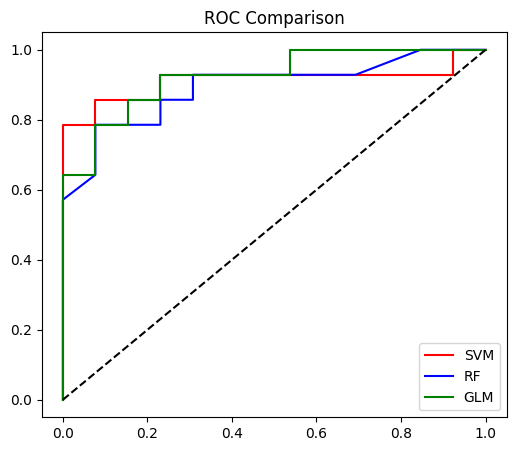

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

plt.figure(figsize=(6,5))

for name,model,color in zip(["SVM","RF","GLM"],
                            [svm,rf,glm],
                            ["red","blue","green"]):
    prob = model.predict_proba(X_test)[:,1]
    fpr,tpr,_ = roc_curve(y_test,prob)
    plt.plot(fpr,tpr,label=name,color=color)

plt.plot([0,1],[0,1],'k--')
plt.title("ROC Comparison")
plt.legend()
plt.show()


##🌡️ 1️⃣1️⃣ Heatmap แบบ paper

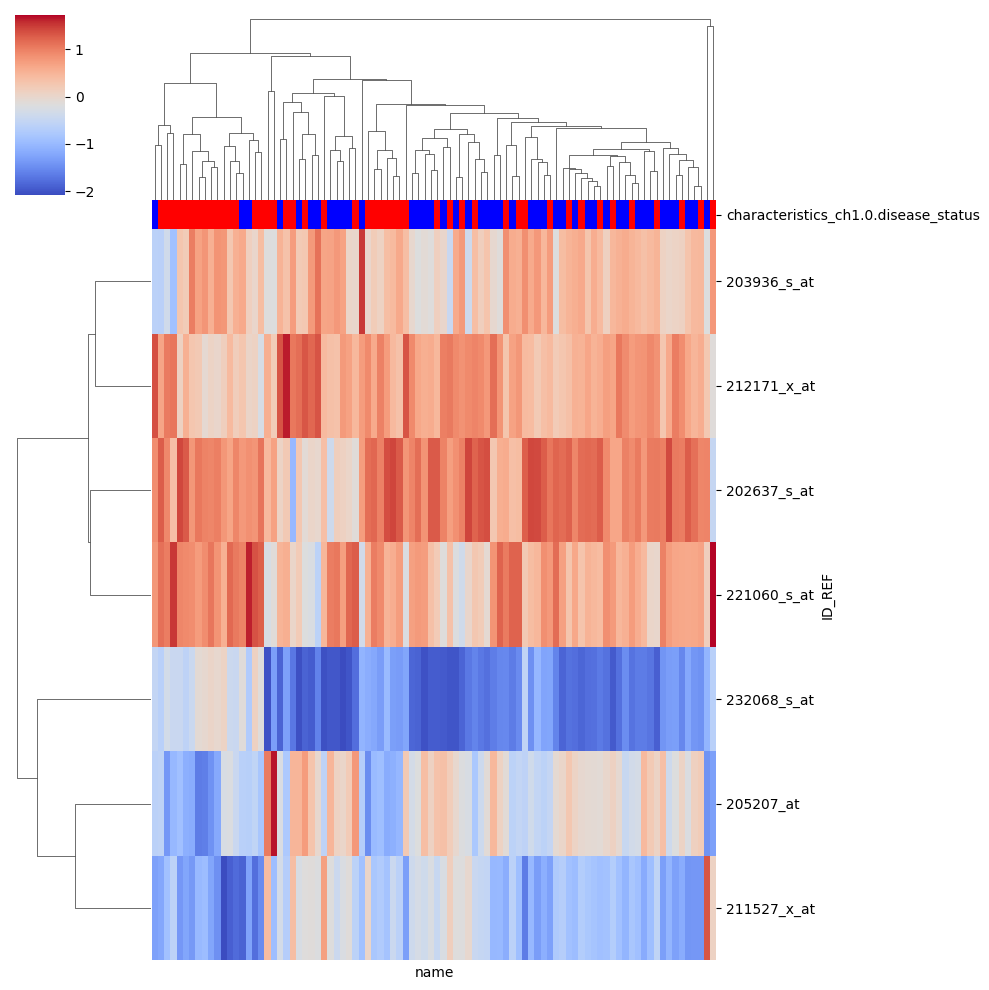

In [11]:
import seaborn as sns

heat = (expr.loc[best_genes] - expr.loc[best_genes].mean()) / expr.loc[best_genes].std()

# Fill any remaining NaN values in the 'heat' DataFrame with 0
# This is necessary because clustermap's underlying clustering algorithm cannot handle NaN values.
heat = heat.fillna(0)

sns.clustermap(heat,
               col_colors=group.map({"Control":"blue","MI":"red"}),
               cmap="coolwarm",
               xticklabels=False)
plt.show()

##💾 1️⃣2️⃣ Save Biomarkers

In [12]:
pd.DataFrame(best_genes, columns=["Gene"]).to_csv("Final_Biomarkers.csv", index=False)


##สรุป

STEP 1 ทำการดาวน์โหลดข้อมูลยีนจากฐานข้อมูล GEO ชุด GSE66360 และแปลงให้อยู่ในรูปเมทริกซ์การแสดงออกของยีน พร้อมข้อมูลลักษณะตัวอย่างของผู้ป่วย เพื่อใช้ในการวิเคราะห์ต่อไป

STEP 2 ลบตัวอย่างที่ถูกกำหนดว่าเป็น outliers ออกจากทั้งเมทริกซ์ยีนและข้อมูลผู้ป่วย โดยใช้รายชื่อ GSM ID ที่ระบุไว้ล่วงหน้า

STEP 3 ทำการปรับสเกลข้อมูล โดยแปลงค่าเป็น log2 และทำ quantile normalization เพื่อทำให้การกระจายของค่าการแสดงออกของยีนในทุกตัวอย่างมีรูปแบบใกล้เคียงกัน

STEP 4 สร้างตัวแปรกลุ่มตัวอย่าง แบ่งเป็นกลุ่มผู้ป่วย Myocardial Infarction และกลุ่ม Control โดยอาศัยข้อมูล phenotype ในไฟล์ GEO

STEP 5 วิเคราะห์ความแตกต่างของการแสดงออกของยีนระหว่างสองกลุ่ม โดยใช้สถิติ t-test แบบสองกลุ่มอิสระ และคัดเลือกยีนที่มีค่า p-value น้อยกว่า 0.05 และมีค่า absolute log fold change มากกว่า 1

STEP 6 เพิ่มยีนที่กำหนดไว้ล่วงหน้าจากงานวิจัยอื่นเข้าไปในชุดยีนผู้สมัคร และทำการแมปชื่อยีนกับ probe ID จากตาราง annotation ของแพลตฟอร์ม GEO เพื่อดึงข้อมูลการแสดงออกของยีนเหล่านั้น

STEP 7 ใช้ LASSO logistic regression ในการคัดเลือกยีน โดยให้โมเดลเลือกเฉพาะยีนที่มีค่าสัมประสิทธิ์ไม่เป็นศูนย์

STEP 8 ใช้ Random Forest ร่วมกับวิธี Recursive Feature Elimination เพื่อลดจำนวนยีนเพิ่มเติมให้เหลือจำนวนที่กำหนด และได้ชุดยีน biomarker สุดท้าย

STEP 9 ใช้ยีนที่คัดเลือกได้สร้างโมเดลจำแนกประเภท ได้แก่ Support Vector Machine, Random Forest และ Logistic Regression โดยแบ่งข้อมูลเป็นชุดฝึกและชุดทดสอบ

STEP 10 ประเมินประสิทธิภาพโมเดลด้วยกราฟ ROC และคำนวณค่า AUC เพื่อวัดความสามารถในการแยกกลุ่มผู้ป่วยและกลุ่มปกติ

STEP 11 สร้าง heatmap ของยีน biomarker เพื่อแสดงรูปแบบการแสดงออกของยีนในแต่ละกลุ่มตัวอย่าง

STEP 12 บันทึกรายชื่อยีน biomarker ที่ได้จากการคัดเลือกลงไฟล์สำหรับใช้งานต่อไป

-----------------------------------------------------------------------------------------------------------------------------------------------------------

##🧬 STEP 0 — ติดตั้งไลบรารี (Colab)

In [13]:
!pip install GEOparse gseapy pandas numpy scikit-learn seaborn matplotlib statsmodels


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.3/605.3 kB 14.9 MB/s eta 0:00:00


##🧬 STEP 1 — โหลดข้อมูลจาก GEO

In [14]:
import GEOparse, pandas as pd, numpy as np

gse = GEOparse.get_GEO("GSE66360", destdir=".")
expr = gse.pivot_samples('VALUE')   # gene expression matrix
pheno = gse.phenotype_data


01-Feb-2026 21:11:11 DEBUG utils - Directory . already exists. Skipping.
DEBUG:GEOparse:Directory . already exists. Skipping.
01-Feb-2026 21:11:11 INFO GEOparse - File already exist: using local version.
INFO:GEOparse:File already exist: using local version.
01-Feb-2026 21:11:11 INFO GEOparse - Parsing ./GSE66360_family.soft.gz: 
INFO:GEOparse:Parsing ./GSE66360_family.soft.gz: 
01-Feb-2026 21:11:11 DEBUG GEOparse - DATABASE: GeoMiame
DEBUG:GEOparse:DATABASE: GeoMiame
01-Feb-2026 21:11:11 DEBUG GEOparse - SERIES: GSE66360
DEBUG:GEOparse:SERIES: GSE66360
01-Feb-2026 21:11:11 DEBUG GEOparse - PLATFORM: GPL570
DEBUG:GEOparse:PLATFORM: GPL570
/usr/local/lib/python3.12/dist-packages/GEOparse/GEOparse.py:401: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(StringIO(data), index_col=None, sep="\t")
01-Feb-2026 21:11:15 DEBUG GEOparse - SAMPLE: GSM1620819
DEBUG:GEOparse:SAMPLE: GSM1620819
01-Feb-2026 21:11:15 DEBUG GEOparse 

##🧬 STEP 2 — Remove Outliers (ตามงานวิจัย)

In [15]:
outliers = ["GSM1620857","GSM1620858","GSM1620894","GSM1620899",
            "GSM1620912","GSM1620872","GSM1620885","GSM1620892","GSM1620913"]

expr = expr.drop(columns=outliers, errors="ignore")
pheno = pheno.drop(outliers, errors="ignore")


##🧬 STEP 3 — Log2 + Quantile Normalize

In [16]:
expr = np.log2(expr + 1)

# quantile normalization
rank_mean = expr.stack().groupby(expr.rank(method='first').stack().astype(int)).mean()
expr = expr.rank(method='min').stack().astype(int).map(rank_mean).unstack()


##🧬 STEP 4 — สร้างกลุ่ม MI vs Control

In [17]:
# Dynamically find the characteristic column for disease status
disease_status_col = None
characteristic_columns = [col for col in pheno.columns if col.startswith('characteristics_ch1')]

if characteristic_columns:
    # Assume the first characteristic column is the one of interest
    disease_status_col = characteristic_columns[0]
else:
    # If no 'characteristics_ch1.X' columns are found, try 'title' as a fallback
    print("Warning: No 'characteristics_ch1.X' columns found. Attempting to use 'title' column for grouping.")
    disease_status_col = 'title'

if disease_status_col == 'title':
    # Special handling for 'title' column, assuming pattern like "Muse_X_DISCOVERY_Control" or "Myocardial Infarction"
    group = pheno[disease_status_col].apply(
        lambda x: 'Control' if 'Control' in x else ('MI' if 'Myocardial Infarction' in x or 'MI' in x else np.nan)
    ).dropna()
else:
    # General handling for characteristic columns
    # Assumes "Key: Value" format like "disease status: Control"
    group = pheno[disease_status_col].apply(
        lambda x: x.split(': ')[1].strip() if isinstance(x, str) and ': ' in x else x
    ).replace({
        "Control": "Control", # Ensure 'Control' is correctly mapped
        "Myocardial Infarction": "MI" # Ensure 'Myocardial Infarction' is correctly mapped to 'MI'
    })

y = group.map({"Control":0,"MI":1})

##🧬 STEP 5 — Differential Expression (แทน limma ด้วย t-test)

In [18]:
from scipy.stats import ttest_ind

deg_results = []
for gene in expr.index:
    mi = expr.loc[gene, group=="MI"]
    ctrl = expr.loc[gene, group=="Control"]
    stat,p = ttest_ind(mi, ctrl)
    logfc = mi.mean() - ctrl.mean()
    deg_results.append([gene,logfc,p])

deg = pd.DataFrame(deg_results, columns=["Gene","logFC","p"])
deg_sig = deg[(deg.p < 0.05) & (abs(deg.logFC) > 1)]


##🧬 STEP 6 — บังคับยีนจาก Paper เข้า Candidate Pool

In [19]:
paper_genes = ["IL6","TNF","MMP9","CXCL8","ICAM1",
               "SERPINE1","ITGB2","CCL2","TLR4","VEGFA"]

# Get the list of all candidate genes (DEG + paper genes)
candidate_gene_symbols = list(set(deg_sig.Gene).union(paper_genes))

# Get the platform annotation table from the gse object
if gse.gpls:
    platform_id = list(gse.gpls.keys())[0] # Get the first (and usually only) platform ID
    platform_df = gse.gpls[platform_id].table

    # Create a mapping from Probe ID to Gene Symbol
    # Assuming 'Gene Symbol' column exists and contains the gene names
    if 'Gene Symbol' in platform_df.columns:
        probe_to_gene_map_df = platform_df[['ID', 'Gene Symbol']].dropna(subset=['Gene Symbol'])
        # Filter out placeholder gene symbols like '---'
        probe_to_gene_map_df = probe_to_gene_map_df[probe_to_gene_map_df['Gene Symbol'] != '---']

        # Create a dictionary to map gene symbols to a list of their probe IDs
        # Handles cases where one gene symbol maps to multiple probe IDs, and multiple symbols in one entry
        gene_to_probes = {}
        for _, row in probe_to_gene_map_df.iterrows():
            probe_id = row['ID']
            gene_symbols_str = str(row['Gene Symbol'])
            # Split by '///' to handle entries with multiple gene symbols
            symbols_in_entry = [s.strip() for s in gene_symbols_str.split('///') if s.strip()]
            for symbol in symbols_in_entry:
                if symbol not in gene_to_probes:
                    gene_to_probes[symbol] = []
                gene_to_probes[symbol].append(probe_id)

        # Find all probe IDs that correspond to our candidate gene symbols
        candidate_probe_ids = []
        for gene_symbol in candidate_gene_symbols:
            if gene_symbol in gene_to_probes:
                candidate_probe_ids.extend(gene_to_probes[gene_symbol])

        # Filter the expression data (expr) using these candidate probe IDs
        # Ensure that these probe IDs are actually present in expr.index
        actual_probes_in_expr = expr.index.intersection(candidate_probe_ids)
        expr_candidate = expr.loc[actual_probes_in_expr]
    else:
        print("Error: 'Gene Symbol' column not found in the platform table. Cannot map paper genes.")
        expr_candidate = pd.DataFrame() # Create an empty DataFrame to avoid further errors
else:
    print("Error: No platform information found in the GSE object. Cannot map paper genes.")
    expr_candidate = pd.DataFrame()

##🧬 STEP 7 — LASSO Selection

In [20]:
from sklearn.linear_model import LogisticRegressionCV

X = expr_candidate.T
y = (group=="MI").astype(int)

# Identify valid indices where y is not NaN
valid_indices = y.dropna().index

# Filter both X and y to keep only valid samples
X = X.loc[valid_indices]
y = y.loc[valid_indices]

# Impute remaining NaN values in X with the mean of each column
X = X.fillna(X.mean())

lasso = LogisticRegressionCV(Cs=10, penalty='l1', solver='liblinear',
                             cv=5, scoring='roc_auc').fit(X,y)

lasso_genes = X.columns[lasso.coef_[0]!=0]

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

##🧬 STEP 8 — RFE Selection (เหมือน RF-RFE ในงานวิจัย)

In [21]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=300, random_state=42)
rfe = RFE(rf, n_features_to_select=10)
rfe.fit(X[lasso_genes], y)

best_genes = X[lasso_genes].columns[rfe.support_]
print("Final Biomarkers:", list(best_genes))


Final Biomarkers: ['1552798_a_at', '202628_s_at', '202637_s_at', '202638_s_at', '202859_x_at', '203936_s_at', '205207_at', '211506_s_at', '211527_x_at', '221060_s_at']


##🧬 STEP 9 — Train Models




In [22]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

X_final = expr.loc[best_genes].T

X_train,X_test,y_train,y_test = train_test_split(
    X_final,y,test_size=0.3, stratify=y, random_state=42)

svm = SVC(probability=True).fit(X_train,y_train)
rf  = RandomForestClassifier(n_estimators=300).fit(X_train,y_train)
glm = LogisticRegression().fit(X_train,y_train)


##🧬 STEP 10 — ROC Curve

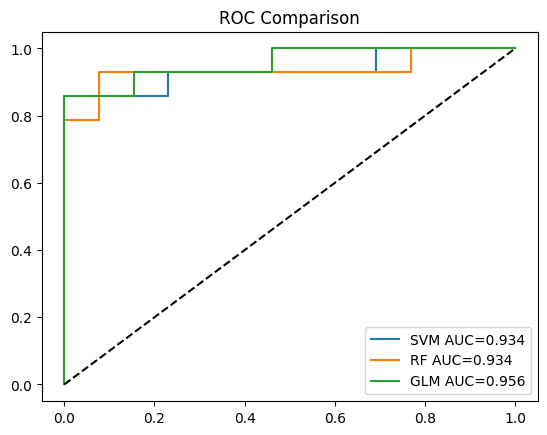

In [23]:
import matplotlib.pyplot as plt

models = {"SVM":svm,"RF":rf,"GLM":glm}

plt.figure()
for name,model in models.items():
    prob = model.predict_proba(X_test)[:,1]
    fpr,tpr,_ = roc_curve(y_test,prob)
    plt.plot(fpr,tpr,label=f"{name} AUC={auc(fpr,tpr):.3f}")

plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.title("ROC Comparison")
plt.show()


##🧬 STEP 11 — Heatmap Biomarkers (แบบ Paper)

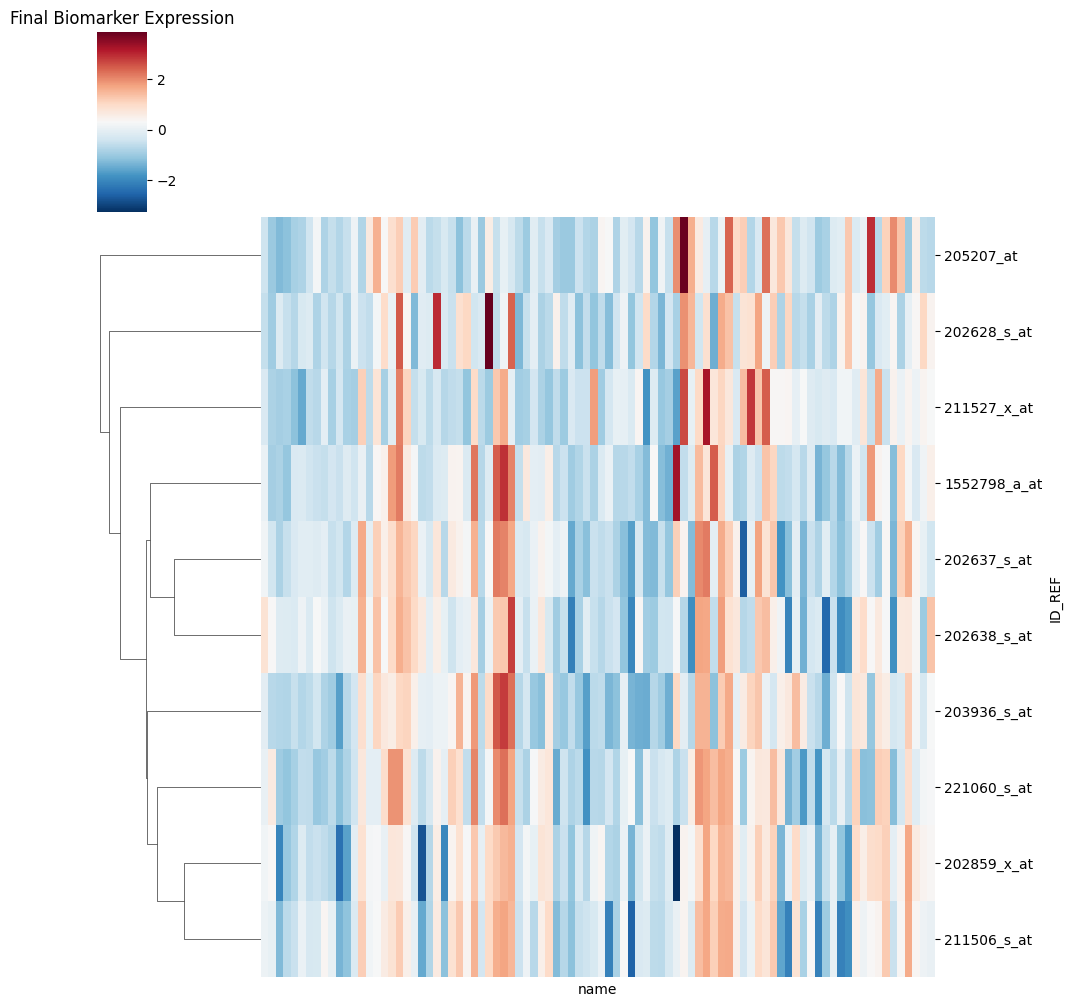

In [24]:
import seaborn as sns

heat = expr.loc[best_genes]
heat = (heat - heat.mean(axis=1).values[:,None]) / heat.std(axis=1).values[:,None]

sns.clustermap(heat, col_cluster=False,
               cmap="RdBu_r", xticklabels=False)
plt.title("Final Biomarker Expression")
plt.show()


##สรุป

STEP 0 ติดตั้งไลบรารีที่ใช้สำหรับการดึงข้อมูล GEO การประมวลผลข้อมูล การวิเคราะห์ทางสถิติ และการสร้างโมเดล machine learning

STEP 1 ดาวน์โหลดชุดข้อมูล GSE66360 จากฐานข้อมูล GEO และจัดข้อมูลให้อยู่ในรูปเมทริกซ์การแสดงออกของยีน พร้อมข้อมูล phenotype ของตัวอย่าง

STEP 2 ลบตัวอย่างที่ระบุว่าเป็น outliers ออกจากเมทริกซ์ยีนและข้อมูล phenotype โดยใช้รายชื่อ GSM ID ที่กำหนดไว้

STEP 3 ทำการแปลงข้อมูลเป็น log2 และทำ quantile normalization เพื่อปรับรูปแบบการกระจายของข้อมูลการแสดงออกของยีนในทุกตัวอย่างให้สอดคล้องกัน

STEP 4 สร้างตัวแปรกลุ่มตัวอย่างโดยแยกเป็น Myocardial Infarction และ Control จากข้อมูล phenotype และเข้ารหัสกลุ่มเป็นตัวเลขเพื่อใช้ในโมเดล

STEP 5 วิเคราะห์หายีนที่มีความแตกต่างระหว่างสองกลุ่ม โดยวนลูปคำนวณ t-test สำหรับแต่ละยีน และคำนวณค่า log fold change จากนั้นคัดเลือกยีนที่มีค่า p-value น้อยกว่า 0.05 และมีค่า |logFC| มากกว่า 1

STEP 6 รวมยีนที่ได้จากการวิเคราะห์ DEG กับยีนที่กำหนดจากแหล่งความรู้ภายนอก แล้วใช้ตาราง annotation ของแพลตฟอร์ม GEO เพื่อแมป gene symbol กับ probe ID และดึงข้อมูลการแสดงออกของ probe เหล่านั้น

STEP 7 ใช้ LASSO logistic regression พร้อม cross-validation เพื่อคัดเลือกยีนที่มีความสำคัญ โดยเก็บเฉพาะยีนที่มีค่าสัมประสิทธิ์ของโมเดลไม่เป็นศูนย์ และทำการเติมค่าที่หายไปด้วยค่าเฉลี่ย

STEP 8 ใช้ Random Forest ร่วมกับ Recursive Feature Elimination เพื่อลดจำนวนยีนจากผล LASSO ให้เหลือจำนวนที่กำหนด และได้ชุดยีน biomarker สุดท้าย

STEP 9 ใช้ชุดยีน biomarker สร้างโมเดลจำแนกประเภท SVM, Random Forest และ Logistic Regression โดยแบ่งข้อมูลเป็นชุดฝึกและชุดทดสอบแบบ stratified

STEP 10 คำนวณค่า ROC curve และ AUC ของแต่ละโมเดล เพื่อประเมินความสามารถในการจำแนกผู้ป่วยกับกลุ่มควบคุม

STEP 11 สร้าง heatmap ของยีน biomarker ที่ได้ โดยทำการปรับสเกลค่าการแสดงออกของแต่ละยีนก่อนแสดงผล